In [5]:
import matplotlib.pyplot as plt
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from scipy.stats import norm
import seaborn as sns
from IPython import display
import numpy as np
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde


def sample_noise(M):
    z = np.float32(np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01)
    return z


def plot_fig(generate, discriminate):
    x = np.random.normal(mu1, sigma1, size=1000)
    y = np.random.normal(mu2, sigma2, size=1000)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=20, edgecolor='r')
    ax.set_axis_bgcolor((0.3, 1, 1))
    plt.grid(False)
    plt.axis([-10, 10, -10, 10])
    
    z1 = sample_noise(M)
    z2 = sample_noise(M)
    z = np.column_stack((z1, z2))
    gs = generate(z)
    plt.scatter(gs[:,0],gs[:,1],c='b')
    
    
    for i in range(-10, 10):
        for j in range(-10, 10):
            #plt.scatter(i, j, c='r')
            intensity = discriminate(np.column_stack((i, j)))[0][0]
            plt.scatter(i, j, c=(intensity, intensity, intensity))
    
    
    #plt.show()
    #print("dis = ", discriminate(np.column_stack((1, -5))))

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/home/hayk/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


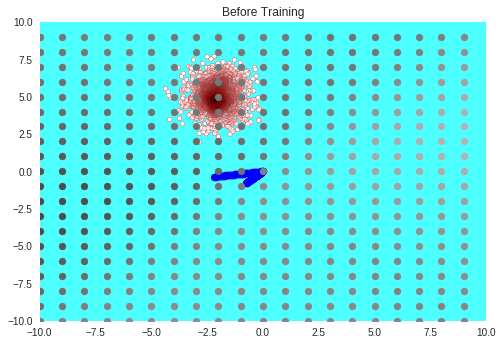

In [2]:
mu1 = -2
sigma1 = 0.7
mu2 = 5
sigma2 = 1
M = 200

# generator
G_input = T.matrix('Gx')
G_l1 = lasagne.layers.InputLayer((None, 2), G_input)
G_l2 = lasagne.layers.DenseLayer(G_l1, 30, nonlinearity=rectify)
G_l3 = lasagne.layers.DenseLayer(G_l2, 30, nonlinearity=rectify)
G_l4 = lasagne.layers.DenseLayer(G_l3, 2, nonlinearity=linear)
G = G_l4

G_out = lasagne.layers.get_output(G)

# discriminators
D1_input = T.matrix('D1x')
D1_target = T.matrix('D1y')
D1_l1 = lasagne.layers.InputLayer((None, 2), D1_input)
D1_l2 = lasagne.layers.DenseLayer(D1_l1, 30, nonlinearity=tanh)
D1_l3 = lasagne.layers.DenseLayer(D1_l2, 30, nonlinearity=tanh)
D1_l4 = lasagne.layers.DenseLayer(D1_l3, 1, nonlinearity=sigmoid)
D1 = D1_l4

D2_l1 = lasagne.layers.InputLayer((None, 2), G_out)
D2_l2 = lasagne.layers.DenseLayer(D2_l1, 30, nonlinearity=tanh, W=D1_l2.W, b=D1_l2.b)
D2_l3 = lasagne.layers.DenseLayer(D2_l2, 30, nonlinearity=tanh, W=D1_l3.W, b=D1_l3.b)
D2_l4 = lasagne.layers.DenseLayer(D2_l3, 1, nonlinearity=sigmoid, W=D1_l4.W, b=D1_l4.b)
D2 = D2_l4

D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)

# output functions
discriminate = theano.function([D1_input], D1_out)
generate = theano.function([G_input], G_out)


G_obj = (T.log(D2_out)).mean()
D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

# parameters update and training
G_params = lasagne.layers.get_all_params(G, trainable=True)
G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
G_updates = lasagne.updates.nesterov_momentum(1 - G_obj, G_params, learning_rate=G_lr, momentum=0.6)
G_train = theano.function([G_input], G_obj, updates=G_updates)

D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
D_updates = lasagne.updates.nesterov_momentum(1 - D_obj, D_params, learning_rate=D_lr, momentum=0.6)
D_train = theano.function([G_input, D1_input], D_obj, updates=D_updates)

plot_fig(generate, discriminate)
plt.title('Before Training')
plt.show()



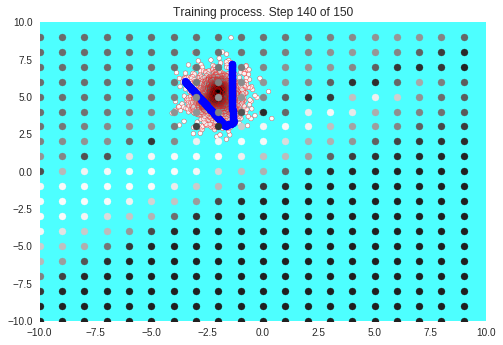

In [3]:
epochs = 150
k = 20

visualize_training = True  # set to True to monitor training progress

plt.ion()

for i in range(epochs):
    for j in range(k):
        x1 = np.float32(np.random.normal(mu1, sigma1, M))  # sampled m-batch from p_data
        x2 = np.float32(np.random.normal(mu2, sigma2, M))
        x=np.column_stack((x1,x2))
        z1 = sample_noise(M)  # sample m-batch from noise prior
        z2 = sample_noise(M)
        z = np.column_stack((z1, z2))
        D_train(z, x)
    z1 = sample_noise(M)
    z2 = sample_noise(M)
    z = np.column_stack((z1, z2))
    G_train(z)
    
    if i % 10 == 0:
        G_lr *= 0.999
        D_lr *= 0.999
        if visualize_training:
            #axes = plt.gca()
            #axes.set_xlim([mu-1, mu+1])
            #axes.set_ylim([mu-1, mu+1])
            plt.clf()
            plot_fig(generate, discriminate)
            plt.title('Training process. Step {} of {}'.format(i,epochs))
            plt.show()
            display.clear_output(wait=True)
        

/home/hayk/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


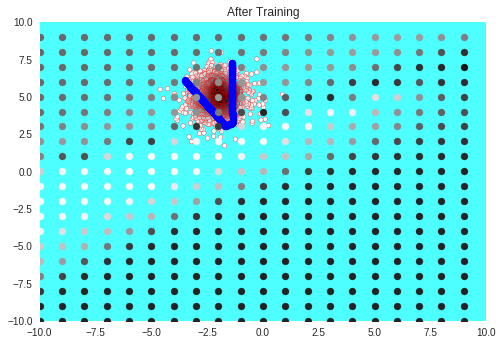

In [7]:
plot_fig(generate, discriminate)
plt.title('After Training')
plt.show()